This is the preliminary notebook for the building of a decision tree classifier for a diabetes dataset that I obtained from [Kaggle](https://www.kaggle.com/brandao/diabetes?select=diabetic_data.csv).

The dataset represents 10 years of clinical data (between 1999 and 2008) across 130 US hospitals and integrated delivery networks, where each row of the dataset represents a patient's inpatient encounter with a hospital for at least 1 day and at most 14 days of length in stay, due to diabetic-related complications. It includes over 50 features representing patient and hospital outcomes, such as:

- patient number
- race
- gender
- age
- admission type
- hospital time
- medical specialty of admitting physician
- number of lab tests performed
- HbA1c test result

...and more. The full list and descriptions of each feature may be found in this [table](https://www.hindawi.com/journals/bmri/2014/781670/tab1/). 

It is important to note that the dataset contains the target variable of my decision tree classifier - `readmitted`, which refers to **days to inpatient READMISSION**. A patient may be readmitted in **less than 30 days** of his or her previous inpatient hospital admission, **more than 30 days**, or have **no record of readmission**. 

The decision tree classifier seeks to predict whether or not a patient would be readmitted based on the features of the dataset. 

Succeeding with high accuracy in this prediction exercise allows us to understand factors that contribute to the readmission patterns of patients, thus allowing for a more personalised and targeted approach in care provision for the improvement of patients' health and wellbeing. It would also allow hospitals to manage resources effectively and ahead of time, reducing the costs of healthcare expenditure while improving the quality of care. 

So, essentially, this exercise seeks to answer 2 questions:
1. What are the strongest predictors of hospital readmission for diabetic patients?
2. Can we predict hospital readmission for diabetes patients, and how accurately? 

In [29]:
# import libraries
import pandas as pd
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

import pydotplus
import matplotlib.pyplot as plt
import matplotlib.image as pltimg
import seaborn as sns

%matplotlib inline

In [30]:
# import dataset
df = pd.read_csv('./data/diabetic_data.csv')
len(df)

101766

There are 50 variables for 101,766 patients

In [31]:
# explore dataset
df.shape

(101766, 50)

### Data fixes

Does not look like there are missing values in any of the variables

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

What about patient duplicates?

I will look at `patient_nbr` for any duplicated ids. This column indicates the unique identifier of a patient. 

Out of 101,766 patients in the dataset, 71,518 of them have duplicated `patient_nbr` ids. 

It may be that a 'unique' identifier is the same for different patients who attend different hospitals, hence, the identifiers given are not in sync across hospitals. 

In any case, even if there are duplicated patients in the dataset, the purpose of the dataset remains valid in the sense that each row represents a separate encounter of a patient with a hospital - each row is a unique event of a patient's inpatient hospital encounter.

In [33]:
df['patient_nbr'].nunique()

71518

In [34]:
df[df['patient_nbr'].duplicated()].sort_values(['patient_nbr']).head(10)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
4780,26264286,135,Caucasian,Female,[50-60),?,1,1,7,3,...,No,No,No,No,No,No,No,Ch,Yes,>30
24642,83281464,1152,AfricanAmerican,Female,[60-70),?,1,1,7,12,...,No,Up,No,No,No,No,No,Ch,Yes,NO
23623,80742510,1152,AfricanAmerican,Female,[60-70),?,1,1,7,8,...,No,Steady,No,No,No,No,No,No,Yes,>30
14180,55533660,1152,AfricanAmerican,Female,[60-70),?,1,1,7,10,...,No,Steady,No,No,No,No,No,No,Yes,>30
5953,30180318,1152,AfricanAmerican,Female,[50-60),?,1,1,7,6,...,No,Down,No,No,No,No,No,Ch,Yes,>30
19765,70190028,1314,Caucasian,Female,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,No,Yes,<30
19914,70601076,1314,Caucasian,Female,[40-50),?,1,1,7,3,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
6901,33503946,5220,Caucasian,Male,[70-80),?,2,1,1,11,...,No,Steady,No,No,No,No,No,No,Yes,>30
16105,60892254,5220,Caucasian,Male,[70-80),?,1,1,7,1,...,No,Steady,No,No,No,No,No,No,Yes,NO
14128,55397514,5220,Caucasian,Male,[70-80),?,2,6,1,8,...,No,Steady,No,No,No,No,No,No,Yes,>30


However, we do see some odd data inputs, such as the `weight` column containing `?` as values.

Let's look for any other of these types of data issues to be fixed, which includes variables with missing values.

1) 97% of patients (n=98,569) have `?` as their weights

2) 2% of patients (n=2,273) have no race assigned to them 

3) 52% of patients (n=40,256) have no payer codes assigned to them

4) 53% of medical specialties of the admitting physician (n=49,949) are missing


In [35]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


Look at `weight`. 97% of weights were not filled. This is a large portion of the dataset. Removing rows with missing weights simply won't do, as this would equate to removing 97% of all rows.

I will remove `weight` from my classifier.

In [36]:
df.query('weight == "?"')

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,443847548,100162476,AfricanAmerican,Male,[70-80),?,1,3,7,3,...,No,Down,No,No,No,No,No,Ch,Yes,>30
101762,443847782,74694222,AfricanAmerican,Female,[80-90),?,1,4,5,5,...,No,Steady,No,No,No,No,No,No,Yes,NO
101763,443854148,41088789,Caucasian,Male,[70-80),?,1,1,7,1,...,No,Down,No,No,No,No,No,Ch,Yes,NO
101764,443857166,31693671,Caucasian,Female,[80-90),?,2,3,7,10,...,No,Up,No,No,No,No,No,Ch,Yes,NO


In [37]:
df1 = df.copy()
del df1['weight']

In [38]:
df1.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),6,25,1,1,?,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),1,1,7,3,?,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),1,1,7,2,?,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),1,1,7,2,?,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),1,1,7,1,?,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


What about the missing races?

I wonder what other races are constituted as `Other` in the `race` column. Mixed races perhaps?

I will replace the missing races as `Undisclosed`. I had initially thought of grouping the missing races as `Other`, but perhaps there is a difference between the identification as `Other` and not wanting to be identified, which might have a pattern in certain patient or hospital outcomes. 

In [39]:
df1['race'].value_counts()

Caucasian          76099
AfricanAmerican    19210
?                   2273
Hispanic            2037
Other               1506
Asian                641
Name: race, dtype: int64

In [40]:
df1['race'] = df1['race'].str.replace('?', 'Undisclosed')
df1['race'].value_counts()

<ipython-input-40-46cca76d0da6>:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df1['race'] = df1['race'].str.replace('?', 'Undisclosed')


Caucasian          76099
AfricanAmerican    19210
Undisclosed         2273
Hispanic            2037
Other               1506
Asian                641
Name: race, dtype: int64

Missing payer codes?

There are supposed to be 23 distinct payer codes. 

Since half of all patients of the dataset did not have their payer method specified, I will not be using `payer_code` in my classifier - similar with `medical_specialty`, seeing as slightly more than 50% of patients of the dataset had no information on the medical specialty of their attending doctor upon inpatient admission. 

In [41]:
df1['medical_specialty'].value_counts()

?                                   49949
InternalMedicine                    14635
Emergency/Trauma                     7565
Family/GeneralPractice               7440
Cardiology                           5352
                                    ...  
Neurophysiology                         1
SportsMedicine                          1
Surgery-PlasticwithinHeadandNeck        1
Proctology                              1
Dermatology                             1
Name: medical_specialty, Length: 73, dtype: int64

In [66]:
# remove 'payer_code' and 'medical_specialty' from my dataset
df1.drop(['payer_code', 'medical_specialty'], axis=1, inplace=True)

In short, I [dealt with these missing data across my categorical variables](https://discuss.analyticsvidhya.com/t/how-to-handle-missing-values-of-categorical-variables/310) by means of ignoring them entirely and treating the missing data as another category (replacing missing races with 'Undisclosed').


## Data exploration

Let's understand what each feature means:

1) `encounter_id`: unique identifier of an encounter

2) `patient_nbr`: unique identifier of a patient
- I will not be including `encounter_id` and `patient_nbr` in my classifier, as they do not provide me with any insights of the dataset but mere markers of each patient's inpatient encounter with a hospital and the patient itself

3) `race`: the race of a patient, either a Caucasian, Asian, African American, Hispanic, other, and undisclosed
- Take note that I'd need to feature engineer these categorical variables into numeric values before feeding my classifier to the data.
- I will apply one-hot encoding to `race`, seeing as it is a nominal categorical variable, aka it does not have some sort of hierarchy or order to the race values. 

4) `gender`: female or male. I will apply one-hot encoding to `gender` also.

5) `age`: in the database, the ages of patients are grouped into 10-year intervals, such as 0-10, 10-20, 20-30 etc. 
- Based on a visualisation below where I plot a clustered bar chart of the ages of patients, it looks like (a) the number of inpatient encounters due to diabetic-related complications increase as age increases to 80 years old; (b) as age increases, the difference in readmission pattern becomes more stark (see the relative proportion of no readmission vs readmission < 30 and > 30 days); and (c) a higher number of no readmission is observed across all age groups (regardless of relative proportion of readmission pattern)
- I will apply one-hot encoding to `age`.

6) `admission_type`: 9 distinct integers representing the admission types
- 1: emergency; 2: urgent; 3: elective; 4: newborn; 5: not available; 6: NULL; 7: trauma; 8: not mapped
- 10% of the dataset contains either `not available`, `NULL`, or `not mapped` as the admission types. I will group these 3 into `others`. 
- I will also group `trauma` and `newborn` cases into `others`, seeing as these two only make up 0.03% of all cases. 
- I will be mapping the integers into their respective admission types. This would allow me to apply one-hot encoding to the nominal categorical variable.

7) `discharged_disposition_id`: 29 distinct discharges, such as a patient being discharged back home upon his or her inpatient encounter, being discharged to another medical institution (with different variations of such institutions such as `another short term hospital`, `inpatient care institution`, `home with some health service`, `home under home IV provider`, `federal health care facility` etc. 
- Based on the bar chart below, a majority of patients were discharged back home (60%), with the next largest proportion (14%) of patients being discharged/ transferred to a skilled nursing facility (SNF), followed by being discharged back home with home health services (13%).
- Given the great disparity of different discharged dispositions, I will group all discharges to destinations with some form of health care provision as `discharged to another medical facility`, and the remaining such as `left AMA`, `expired`, `null`, `not mapped` into `others`. 
- Ultimately, this column would only contain 3 unique types of discharged dispositions: `discharged to home`, `discharged to another medical facility`, and `others`. These should cover the range of discharge modes. 

8) `admission_source_id`: 21 distinct admission sources, such as a patient's encounter due to physicial referral, clinic referral, emergency referral etc.
- Seems like a lot of variation of referrals. I myself am also unsure of the distictions between these referral points. 
- A bar chart below shows me that a majority of admission source comes from emergencies, followed by physician referrals. 
- In this case, I will reclassify the admission source to `emergency referral`, `non-emergency referral`, and `others` containing missing sources.

9) `time_in_hospital`: numeric values indicating number of days between admission and discharge. The shortest number of days was 1 and the longest was 13 days. Data is right-skewed, with lesser people spending longer days between admission and discharge. 

10) `num_lab_procedures`: numeric values indicating number of lab tests performed during the admission. The least number of lab tests performed was 1 and the most was 132. Data is also right-skewed, with lesser patients having high number of lab tests performed.

11) `num_procedures`: numeric values indicating number of procedures other than lab tests performed during the encounter. Most patients of the dataset had 0 non-lab procedures performed.

12) `number_outpatient`: numeric values indicating number of outpatient visits of patient in the preciding year before the encounter

13) `diag_1`, `diag_2`, and `diag_3`: the primary, secondary, and additional secondary diagnosis of each patient, as recorded in the ICD9 three-digit codes
- Since all encounters recorded in the dataset are diabetes-related, the diagnoses would be related to diabetes. As such, I will not be using these columns in my classifier. I would simply take it as these patients were admitted to the hospital due to diabetic-related complications, without taking into account a more granular view of their diagnoses.

14) `number_diagnoses`: numeric values indicating number of diagnoses entered into the system. I won't be taking this variable into my classifier too.

15) `max_glu_serum`: range of results of glucose serum test recorded in categorical values - `>200`, `>300`, `normal`, or `none` if the test was not taken.
- For 95% of the patients in the dataset, the glucose serum test was not performed. 

16) `A1Cresult`: range of results of A1c test recorded in categorical values - `>8`, `norm`, `>7`, or `none` if test was not taken.
- 83% of patients did not take this test. 

17) `change`: indicates if there had been a change in diabetic medications. If yes, then `Ch` was recorded, if not, then `No` was recorded.

18) `diabetesMed`: indicates if any diabetic medication was prescribed. If yes, then `yes` was recorded, if no, then `no` was recorded. 

19) 24 features for medications
- 24 different medications were recorded in the dataset as either having their dose increased, decreased, remained the same, or not prescribed.
- For example, variable `metformin` has 4 unique values to it: `no`, `steady`, `up`, or `down`, each indicating whether the medication was not given to the patient, was given in the same dosage as before, had its dosage increased from before, or had its dosage decreased from before, respectively. 
- However, there are two medications: `citoglipton` and `examide` where all values in these 2 columns are `no`. I will drop these columns as they provide me with no insight.


**Data fix 1: Plot clustered bar chart for readmission type across age groups**

/opt/anaconda3/envs/python_test/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


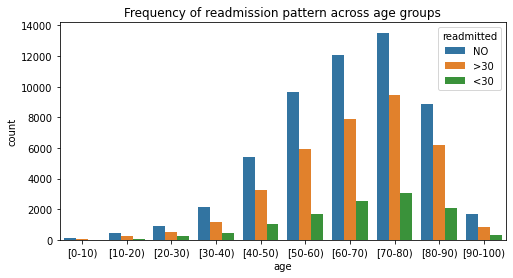

In [42]:
plt.figure(figsize=(8,4))
sns.countplot(df1['age'], hue=df1['readmitted'])
plt.title('Frequency of readmission pattern across age groups');

**Data fix 2: Map admission type from integer to object and group null values together as `Undisclosed`**

In [43]:
admission_type_dict = {1:'emergency',
                       2:'urgent',
                       3:'elective',
                       4:'others',
                       5:'others',
                       6:'others',
                       7:'others',
                       8:'others'}

df1['admission_type_id'] = df1['admission_type_id'].map(admission_type_dict)
df1['admission_type_id'].value_counts()

emergency    53990
elective     18869
urgent       18480
others       10427
Name: admission_type_id, dtype: int64

**Data fix 3: Frequency of discharge reasons**

/opt/anaconda3/envs/python_test/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


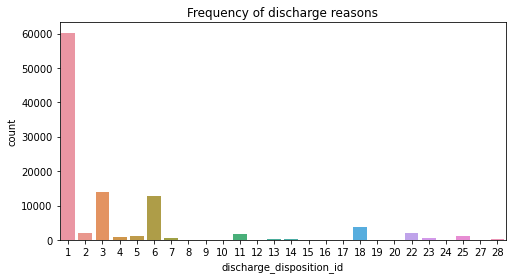

In [44]:
plt.figure(figsize=(8,4))
sns.countplot(df1['discharge_disposition_id'])
plt.title('Frequency of discharge reasons');

**Re-classify `discharge_disposition_id` into 3 categories: `discharged to home`, `discharged to another medical facility`, and `others`**

- I will do this by firstly mapping the integers into their dispositions, and later applying a function that looks for specific words in the dispositions to group them into 1 of the 3 categories.
- For example, if a disposition has the word `expire`, then it goes into `others`. Discounting the already clear-cut `discharged to home` dispositions, the remaining ones would automatically be grouped into `discharged to another medical facility`.

In [45]:
# import csv file containing the data maps
data_map = pd.read_csv('./data/id_mapping.csv')

In [46]:
# Create mapping dictionary
discharge_disposition_df = data_map[11:41]
discharge_disposition_df.columns = 'discharge_disposition_id', 'description'
discharge_disposition_df['description'] = discharge_disposition_df['description'].str.lower()
discharge_disposition_df.set_index(['discharge_disposition_id'], inplace=True)
discharge_disposition_df.fillna('none', inplace=True)
discharge_disposition_df.index = discharge_disposition_df.index.astype(int)
discharge_disposition_dict = discharge_disposition_df.to_dict()['description']
discharge_disposition_dict

<ipython-input-46-b1085cec7243>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  discharge_disposition_df['description'] = discharge_disposition_df['description'].str.lower()
/opt/anaconda3/envs/python_test/lib/python3.9/site-packages/pandas/core/frame.py:4462: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


{1: 'discharged to home',
 2: 'discharged/transferred to another short term hospital',
 3: 'discharged/transferred to snf',
 4: 'discharged/transferred to icf',
 5: 'discharged/transferred to another type of inpatient care institution',
 6: 'discharged/transferred to home with home health service',
 7: 'left ama',
 8: 'discharged/transferred to home under care of home iv provider',
 9: 'admitted as an inpatient to this hospital',
 10: 'neonate discharged to another hospital for neonatal aftercare',
 11: 'expired',
 12: 'still patient or expected to return for outpatient services',
 13: 'hospice / home',
 14: 'hospice / medical facility',
 15: 'discharged/transferred within this institution to medicare approved swing bed',
 16: 'discharged/transferred/referred another institution for outpatient services',
 17: 'discharged/transferred/referred to this institution for outpatient services',
 18: 'none',
 19: 'expired at home. medicaid only, hospice.',
 20: 'expired in a medical facility. m

In [47]:
# map dispositions to integers
df1['discharge_disposition_id'] = df1['discharge_disposition_id'].map(discharge_disposition_dict)

In [48]:
# define function for classification based on whether 'expire' is in the discharge disposition
def classify_discharge_disposition(df):
    if 'expire' in df:
        return 'others'
    if 'left' in df:
        return 'others'
    if 'none' in df:
        return 'others'
    if 'not mapped' in df:
        return 'others'
    if 'unknown' in df:
        return 'others'
    elif 'discharged to home' in df:
        return 'discharged to home'
    else:
        return 'discharged to another medical facility'

In [49]:
# apply function
df1['discharge_disposition_id_check'] = df1['discharge_disposition_id'].apply(classify_discharge_disposition)
df1['discharge_disposition_id_check'].value_counts()

discharged to home                        60234
discharged to another medical facility    34577
others                                     6955
Name: discharge_disposition_id_check, dtype: int64

In [50]:
df1[['discharge_disposition_id', 'discharge_disposition_id_check']].sample(n=20)

,discharge_disposition_id,discharge_disposition_id_check
70745,discharged/transferred to another short term h...,discharged to another medical facility
21304,discharged to home,discharged to home
48892,discharged to home,discharged to home
38289,discharged/transferred to snf,discharged to another medical facility
100625,discharged to home,discharged to home
17558,none,others
1164,discharged to home,discharged to home
9672,none,others
69368,discharged/transferred to another short term h...,discharged to another medical facility
76752,discharged/transferred to snf,discharged to another medical facility


In [51]:
df1['discharge_disposition_id'] = df1['discharge_disposition_id_check']
del df1['discharge_disposition_id_check']

/opt/anaconda3/envs/python_test/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


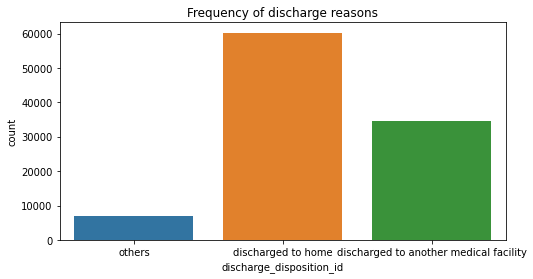

In [52]:
# plot bar chart with new categories
plt.figure(figsize=(8,4))
sns.countplot(df1['discharge_disposition_id'])
plt.title('Frequency of discharge reasons');

**Data fix 4: Frequency of admission sources**

/opt/anaconda3/envs/python_test/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


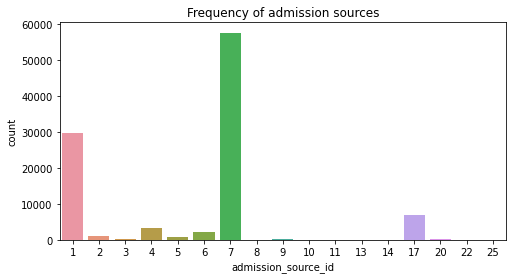

In [53]:
plt.figure(figsize=(8,4))
sns.countplot(df1['admission_source_id'])
plt.title('Frequency of admission sources');

**Re-classify the `admission_source_id` to 3 categories: `emergency referral`, `non-emergency referral`, and `others`**

In [54]:
admission_source_df = data_map[43:]
admission_source_df.columns = ['admission_source_id', 'description']
admission_source_df.fillna('not available', inplace=True)
admission_source_df.set_index(['admission_source_id'], inplace=True)
admission_source_df.index = admission_source_df.index.astype(int)
admission_source_df['description'] = admission_source_df['description'].str.lower()
admission_source_dict = admission_source_df.to_dict()
admission_source_dict = admission_source_dict['description']

/opt/anaconda3/envs/python_test/lib/python3.9/site-packages/pandas/core/frame.py:4462: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
<ipython-input-54-ed22c42c5479>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  admission_source_df['description'] = admission_source_df['description'].str.lower()


In [55]:
# map admissions type to integers
df1['admission_source_id'] = df1['admission_source_id'].map(admission_source_dict)
df1['admission_source_id'] .value_counts()

emergency room                                               57494
physician referral                                           29565
not available                                                 6906
transfer from a hospital                                      3187
transfer from another health care facility                    2264
clinic referral                                               1104
transfer from a skilled nursing facility (snf)                 855
hmo referral                                                   187
not mapped                                                     161
court/law enforcement                                           16
transfer from hospital inpt/same fac reslt in a sep claim       12
transfer from critial access hospital                            8
extramural birth                                                 2
transfer from ambulatory surgery center                          2
normal delivery                                               

In [56]:
# classify admission sources to the 3 categories
def classify_admission_source(df):
    if 'emergency' in df:
        return 'emergency referral'
    if 'not mapped' in df:
        return 'others'
    if 'not available' in df:
        return 'others'
    if 'not mapped' in df:
        return 'others'
    else:
        return 'non-emergency referral'

In [59]:
# apply function
df1['admission_source_id'] = df1['admission_source_id'].apply(classify_admission_source)

**Data fix 5: Histogram of time in hospital in days**

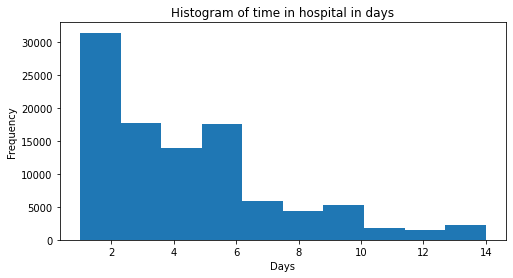

In [88]:
plt.figure(figsize=(8,4))
plt.hist(df1['time_in_hospital'])
plt.title('Histogram of time in hospital in days')
plt.xlabel('Days')
plt.ylabel('Frequency');

Let's look at the relationship between the 3 readmission types and the amount of time spent in the hospital.

Will we see a pattern?

From the boxplots below, we see that patients with no readmission had a lower median number of days spent in hospital between admission and discharge. The median number of days is roughly similar amongst patients that were readmitted before or beyond 30 days of discharge. 

From the histograms below, other than the observation where a much higher number of patients do NOT get readmitted, a higher proportion of patients who do not get readmitted spend shorter days in the hospital. We see that a lower proportion of patients who do get readmitted spend shorter days in the hospital as compared to patients who do get readmitted. Nevertheless, the length of hospital stay between admission and discharge remains the same from 1 to 13 days for patients who do not get readmitted and patients who do get readmitted. 

/opt/anaconda3/envs/python_test/lib/python3.9/site-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/python_test/lib/python3.9/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


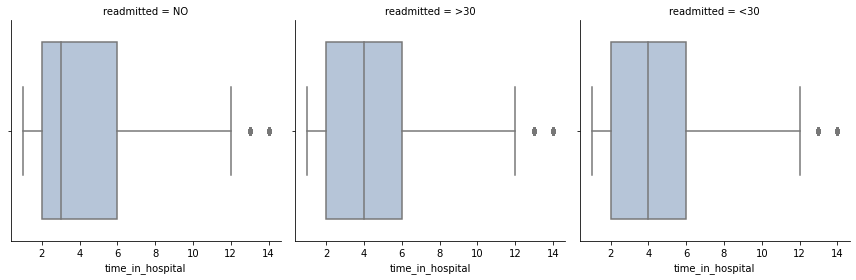

In [110]:
g = sns.FacetGrid(df1, col='readmitted', size=4)
g.map(sns.boxplot, 'time_in_hospital', color='lightsteelblue');

/opt/anaconda3/envs/python_test/lib/python3.9/site-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


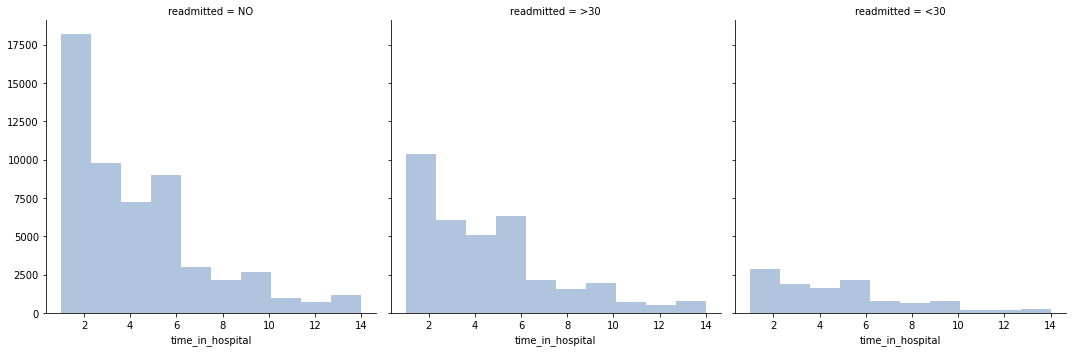

In [111]:
g = sns.FacetGrid(df1, col='readmitted', size=5)
g.map(plt.hist, 'time_in_hospital', bins=10, color='lightsteelblue');

**Data fix 6: Histogram of number of lab tests performed**

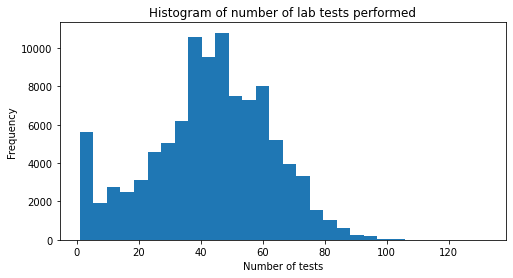

In [85]:
plt.figure(figsize=(8,4))
plt.hist(df1['num_lab_procedures'], bins=30)
plt.title('Histogram of number of lab tests performed')
plt.xlabel('Number of tests')
plt.ylabel('Frequency');

**Data fix 7: Remove `encounter_id`, `patient_bnr`, `diag_1`, `diag_2`, `diag_3`, and `number_diagnoses` from dataset**

In [141]:
df1.drop(['diag_1', 'diag_2', 'diag_3', 'number_diagnoses'], axis=1, inplace=True)
df1.drop(['encounter_id', 'patient_nbr', 'citoglipton', 'examide'], axis=1, inplace=True)

In [146]:
df1.columns

Index(['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient',
       'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton',
       'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

## Feature engineering

Since all of the categorical features are nominal, aka they do not have a natural hierarchy or order to them, I will apply one-hot encoding to all of my categorical features.

These are: race, gender, age, admission_type_id,  discharge_disposition_id, admission_source_id, max_glu_serum, A1Cresult, change, diabetesMed, and the 24 medication features reflecting change in dosage.

In [149]:
for i in df1.columns:
    try:
        df1[i] = df1[i].str.lower()
    except:
        pass

In [159]:
# create df1 copy containing numeric features only. i will concat these with the dummy variables later
df1_numeric = df1.copy()

for i in df1_numeric.columns:
    if df1_numeric[i].dtype == 'O':
        del df1_numeric[i]
    else:
        pass

before creating the dummy variables, I need to relabel the categorical labels, so that the dummy variables would have proper, distinguishable names.

In [177]:
dummies_results_df = pd.DataFrame()

for i in df1.columns:
    if (df1[i].dtype == 'O') & (i == 'race'):
        dummies = pd.get_dummies(df1[i])
        dummies_results_df = dummies_results_df.append(dummies)
    elif (df1[i].dtype == 'O') & (i != 'race'):
        dummies = pd.get_dummies(df1[i])
        dummies_results_df = pd.concat([dummies_results_df, dummies], axis=1)
    else:
        print(i) # should print all the numeric features
        

time_in_hospital
num_lab_procedures
num_procedures
num_medications
number_outpatient
number_emergency
number_inpatient


In [179]:
dummies_results_df.columns

Index(['africanamerican', 'asian', 'caucasian', 'hispanic', 'other',
       'undisclosed', 'female', 'male', 'unknown/invalid', '[0-10)',
       ...
       'steady', 'no', 'steady', 'ch', 'no', 'no', 'yes', '<30', '>30', 'no'],
      dtype='object', length=115)

In [168]:
dummies_results_df = pd.DataFrame()

In [169]:
test = pd.get_dummies(df1['race'])

In [170]:
dummies_results_df = dummies_results_df.append(test)

In [171]:
pd.concat([dummies_results_df, test], axis=1)

,africanamerican,asian,caucasian,hispanic,other,undisclosed,africanamerican,asian,caucasian,hispanic,other,undisclosed
0,0,0,1,0,0,0,0,0,1,0,0,0
1,0,0,1,0,0,0,0,0,1,0,0,0
2,1,0,0,0,0,0,1,0,0,0,0,0
3,0,0,1,0,0,0,0,0,1,0,0,0
4,0,0,1,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
101761,1,0,0,0,0,0,1,0,0,0,0,0
101762,1,0,0,0,0,0,1,0,0,0,0,0
101763,0,0,1,0,0,0,0,0,1,0,0,0
101764,0,0,1,0,0,0,0,0,1,0,0,0
